In [202]:
import pandas as pd
import cv2
import os
import numpy as np
import faiss
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [203]:
import warnings
warnings.simplefilter("ignore")

In [204]:
paths_db = pd.read_csv('database/db.csv', index_col=0)
paths = paths_db['path'].values.tolist()

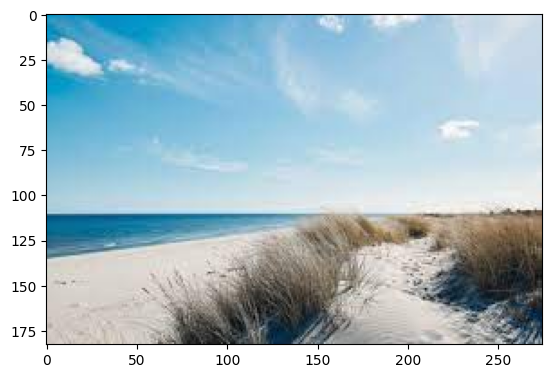

In [205]:
image = cv2.imread(paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [206]:
paths_db.head()

,path
index,
0,archive\Training Data\Coast\Coast-Train (1).jpeg
1,archive\Training Data\Coast\Coast-Train (10).jpeg
2,archive\Training Data\Coast\Coast-Train (100)....
3,archive\Training Data\Coast\Coast-Train (1000)...
4,archive\Training Data\Coast\Coast-Train (1001)...


In [207]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Cargar la ResNet50 preentrenada sin la capa final
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Capa de promedio global para reducir dimensionalidad
x = Dense(1024, activation='relu')(x)  # Capa densa personalizada
x = Dropout(0.5)(x)  # Regularización para evitar sobreajuste
predictions = Dense(1024, activation='softmax')(x)  # Nueva capa de salida con 10 clases



# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)



In [208]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    feature = model.predict(image)
    return feature.flatten()

In [209]:
features = []
for path in paths:
    features.append(extract_features(path))


features = np.array(features)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [210]:
features[0].shape

(1024,)

Probando el modelo

In [211]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_images(query_image_path, image_features, image_paths, model, top_k=5):
    # Extraer características de la imagen de consulta
    query_features = extract_features(query_image_path)

    # Calcular similitud coseno entre la consulta y todas las imágenes
    similarities = cosine_similarity([query_features], image_features)[0]

    similar_indices = np.argsort(similarities)[::-1][:top_k]

    similar_images = [image_paths[i] for i in similar_indices]
    return similar_images


In [212]:
test_image_path = "archive/Testing Data/Mountain/Mountain-Test (4).jpeg"
similar_images = find_similar_images(test_image_path, features, paths, model)

print("Imágenes más similares:")
for img_path in similar_images:
    print(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Imágenes más similares:
archive\Training Data\Glacier\Glacier-Train (1072).jpeg
archive\Training Data\Coast\Coast-Train (100).jpeg
archive\Training Data\Glacier\Glacier-Train (1016).jpeg
archive\Training Data\Forest\Forest-Train (105).jpeg
archive\Training Data\Glacier\Glacier-Train (1019).jpeg


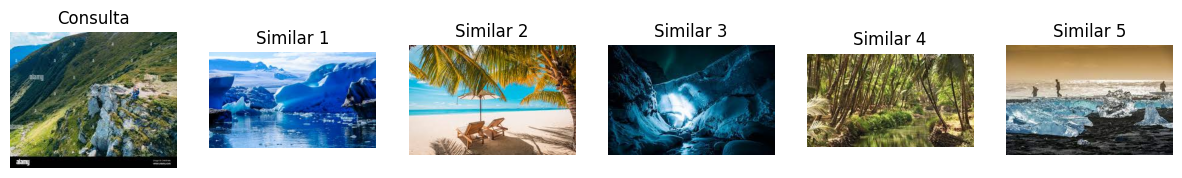

In [213]:
import matplotlib.pyplot as plt

def show_similar_images(query_image, similar_images):
    # Mostrar imagen de consulta
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_image), cv2.COLOR_BGR2RGB))
    plt.title("Consulta")
    plt.axis("off")

    # Mostrar imágenes similares
    for i, img_path in enumerate(similar_images, 2):
        plt.subplot(1, len(similar_images) + 1, i)
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.title(f"Similar {i-1}")
        plt.axis("off")

    plt.show()

# Visualiza las imágenes
show_similar_images(test_image_path, similar_images)


In [214]:
import faiss

# Indexar las características
dimension = features.shape[1]
index = faiss.IndexFlatL2(dimension)  # Índice para búsqueda por distancia L2
index.add(features)

faiss.write_index(index, 'database\cnn.index')


In [215]:
# Buscar las 5 imágenes más cercanas
test_img_path = "archive/Testing Data/Mountain/Mountain-Test (4).jpeg"
query_features = extract_features(test_img_path)
distances, indices = index.search(query_features[np.newaxis, :], k=5)

print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Indices of nearest neighbors: [[382 320   2 257 323]]
Distances to nearest neighbors: [[4.3093712e-07 4.4698390e-07 4.4714278e-07 4.5748155e-07 4.6029652e-07]]


In [216]:
import matplotlib.pyplot as plt

def show_faiss_results(query_image_path, similar_indices, image_paths):
    # Número de resultados a mostrar
    num_results = len(similar_indices)

    # Configurar la figura
    plt.figure(figsize=(15, 5))

    # Mostrar la imagen de consulta
    plt.subplot(1, num_results + 1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB))
    plt.title("Consulta")
    plt.axis("off")

    # Mostrar las imágenes similares

    for i, idx in enumerate(similar_indices, start=2):
        plt.subplot(1, num_results + 1, i)
        similar_image_path = image_paths[idx]
        plt.imshow(cv2.cvtColor(cv2.imread(similar_image_path), cv2.COLOR_BGR2RGB))
        plt.title(f"Similar {i-1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


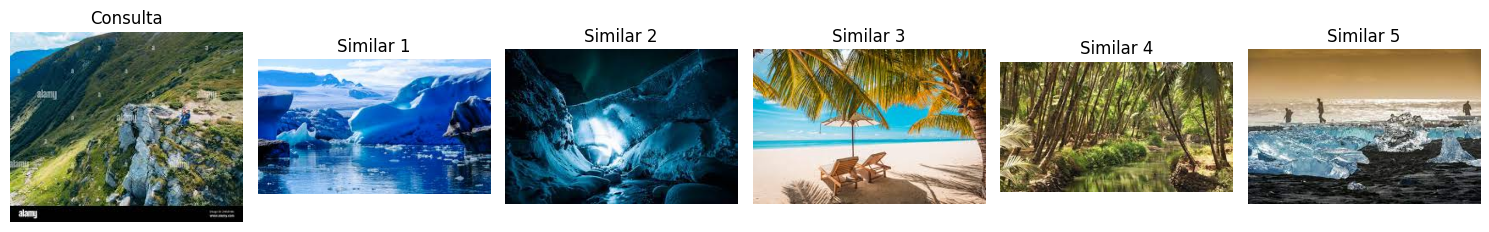

In [217]:
show_faiss_results(test_img_path, indices[0], paths)